# Image similarity search on Azure Cosmos DB for PostgreSQL using the pgvector extension

In this notebook, we will build a basic image similarity search application using the Azure AI Vision multi-modal embeddings APIs and Azure Cosmos DB for PostgreSQL.

In Azure Cosmos DB for PostgreSQL, vector similarity search is enabled by the `pgvector` extension.

Before you start:

1. Create an Azure Cosmos DB for PostgreSQL cluster and enable the `pgvector` extension.
2. Create an Azure Blob Storage container to store the images.
3. Run the `data_preprocessing.ipynb` notebook to clean up the SemArt Dataset and the `generate_embeddings.py` script to compute the embeddings of all the images. The embeddings are saved in the `dataset_embeddings.csv` file in the *dataset* folder.
4. Run the `upload_images_to_blob.py` script to upload the images in your Blob Storage container.
5. Run the `upload_data_to_postgresql.py` script to create a PostgreSQL table and populate it with data.

## Import libraries

In [1]:
import os
import math
import psycopg2
from psycopg2 import pool
from dotenv import load_dotenv
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from azure.storage.blob import ContainerClient

import constants as c
from utils import (
    vectorize_image_with_filepath,
    vectorize_text,
    display_image_grid,
    download_blob,
)

## Load environment variables

In [2]:
load_dotenv("../.env")

# Azure Cosmos DB for PostgreSQL
postgres_host = os.getenv("POSTGRES_HOST")
postgres_database_name = os.getenv("POSTGRES_DB_NAME")
postgres_user = os.getenv("POSTGRES_USER")
postgres_password = os.getenv("POSTGRES_PASSWORD")
sslmode = "require"
table_name = os.getenv("POSTGRES_TABLE_NAME")

# Azure AI Vision
vision_endpoint = os.getenv("VISION_ENDPOINT") + "computervision/"
vision_key = os.getenv("VISION_KEY")
vision_api_version = os.getenv("VISION_VERSION")

# Azure Blob Storage credentials
blob_account_name = os.getenv("BLOB_ACCOUNT_NAME")
blob_account_key = os.getenv("BLOB_ACCOUNT_KEY")
blob_endpoint_suffix = os.getenv("BLOB_ENDPOINT_SUFFIX")
blob_connection_string = (
    f"DefaultEndpointsProtocol=https;AccountName={blob_account_name};"
    f"AccountKey={blob_account_key};EndpointSuffix={blob_endpoint_suffix}"
)
container_name = os.getenv("CONTAINER_NAME")

## Create an Azure Blob Storage container client

Create an Azure Blob Storage `ContainerClient` object to download images from your container. Alternatively, you can display the images using their public URL.

In [3]:
blob_container_client = ContainerClient.from_connection_string(
    conn_str=blob_connection_string,
    container_name=container_name,
)

## Connect to Azure Cosmos DB for PostgreSQL

The following code forms a connection string using the environment variables for your Azure Cosmos DB for PostgreSQL cluster and creates a connection pool to your Postgres database. After that, a `cursor` object is created, which can be used to execute SQL queries with the `execute()` method.

In [4]:
# Build a connection string from the variables
postgres_connection_string = (
    f"host={postgres_host} user={postgres_user} dbname={postgres_database_name} "
    f"password={postgres_password} sslmode={sslmode}"
)

In [5]:
postgresql_pool = psycopg2.pool.SimpleConnectionPool(1, 20, postgres_connection_string)
if postgresql_pool:
    print("Connection pool created successfully")

Connection pool created successfully


In [6]:
# Get a connection from the connection pool
conn = postgresql_pool.getconn()
cursor = conn.cursor()

### Select the first 10 rows of the table to see the data

In [7]:
cursor.execute(f"SELECT COUNT(*) FROM {table_name};")
number_of_records = cursor.fetchone()[0]
print(f"Number of records in the table: {number_of_records}")

Number of records in the table: 11206


In [8]:
cursor.execute(f"SELECT * FROM {table_name} LIMIT 10;")
rows = cursor.fetchall()

df_rows = pd.DataFrame(rows, columns=c.COLUMN_NAMES_LIST)
df_rows.head(10)

image_file                                        description  \
0   19873-1darmst.jpg  The Meyer or Darmstadt Madonna is the last, mo...   
1  18759-guard301.jpg  Whereas Canaletto incorporates classically ins...   
2   00930-30coron.jpg  Fra Angelico dedicated several of his works to...   
3  18424-2105grec.jpg  This portrait is an example of El Greco's late...   
4  21949-4lastsu3.jpg  Leonardo's painting of the Last Supper was con...   
5   39738-04organ.jpg  This is another original version of the Venus ...   
6  29467-canal_mo.jpg  Aert Van der Neer painted his first moonlit la...   
7  12035-painstud.jpg  It is assumed that the painter represented in ...   
8  36091-4absalo1.jpg  The large scene on the long wall opposite to t...   
9   20109-44hooch.jpg  Pieter de Hooch depicts for us incidents in th...   

                      author                              title  \
0  HOLBEIN, Hans the Younger                  Darmstadt Madonna   
1          GUARDI, Francesco  Landscape with a Fisherman's Tent   
2              ANGELICO, Fra       The Coronation of the Virgin   
3                  GRECO, El        Portrait of Cardinal Tavera   
4          LEONARDO da Vinci                    The Last Supper   
5           TIZIANO Vecellio   Venus and Cupid with an Organist   
6         NEER, Aert van der               A Canal by Moonlight   
7                DOU, Gerrit              Painter in his Studio   
8     SALVIATI, Cecchino del      The Story of David (4 scenes)   
9           HOOCH, Pieter de             Woman Reading a Letter   

          technique          type  timeframe  \
0   Oil on limewood     religious  1501-1550   
1     Oil on canvas     landscape  1751-1800   
2   Tempera on wood     religious  1401-1450   
3     Oil on canvas      portrait  1551-1600   
4   Mixed technique     religious  1451-1500   
5     Oil on canvas  mythological  1501-1550   
6  Oil on oak panel     landscape  1601-1650   
7        Oil on oak         genre  1651-1700   
8            Fresco     religious  1501-1550   
9     Oil on canvas         genre  1651-1700   

                                              vector  
0  [-6.2070312,-3.2949219,1.4003906,-1.0898438,-4...  
1  [0.6772461,-1.0214844,0.3095703,-1.9599609,-1....  
2  [-3.53125,-0.46362305,0.6982422,-0.9916992,-2....  
3  [-1.2724609,-0.2644043,-0.8095703,-3.0449219,-...  
4  [-1.3525391,1.9355469,0.47802734,-3.25,-2.5175...  
5  [-4.015625,-2.3242188,1.5888672,-6.1679688,-3....  
6  [2.2011719,-0.20983887,1.4208984,-1.3222656,-3...  
7  [0.5541992,-0.24475098,-0.5957031,-1.1962891,-...  
8  [-4.46875,-4.375,-1.1943359,-2.8574219,-0.2359...  
9  [-1.8203125,1.9199219,2.1484375,-0.9355469,-5....

## Search images using an image or a text prompt

After populating the table with vector data, you can use this image collection to search for images that are most similar to a reference image or a text prompt. The workflow is summarized as follows:

1. Use the Vectorize Image API or the Vectorize Text API to generate vector embeddings of an image or text, respectively.
2. To calculate similarity and retrieve images, use `SELECT` statements and the built-it vector operators of the PostgreSQL database.
3. Display the retrieved images using the `display_image_grid()` function.


In [9]:
TOP_N = 12

### Text-to-Image Search

#### Calculate the vector embedding of the text prompt

Let's search for paintings depicting "a table with flowers."

In [10]:
text_prompt = "a table with flowers"
query_vector = vectorize_text(
    text=text_prompt,
    endpoint=vision_endpoint,
    key=vision_key,
    version=vision_api_version,
)

#### Query the table to find the most similar images

In [11]:
# Vector search
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME} "
    f"FROM {table_name} ORDER BY {c.VECTOR_COLUMN_NAME} <=> %s LIMIT {TOP_N};",
    (str(query_vector),),
)

# Retrieve the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(
    rows,
    columns=[c.IMAGE_FILE_COLUMN_NAME, c.AUTHOR_COLUMN_NAME, c.TITLE_COLUMN_NAME]
)
df_rows.head(TOP_N)

image_file                   author  \
0    08537-2still2.jpg            CEZANNE, Paul   
1    14903-early05.jpg            GAUGUIN, Paul   
2   11309-411delac.jpg        DELACROIX, Eugene   
3    08536-2still1.jpg            CEZANNE, Paul   
4   14993-tahiti52.jpg            GAUGUIN, Paul   
5    14909-early11.jpg            GAUGUIN, Paul   
6   17036-flower09.jpg        GOGH, Vincent van   
7   07635-89d_stil.jpg               CARAVAGGIO   
8   06614-bouquet1.jpg  BRUEGHEL, Jan the Elder   
9   17114-3arles28.jpg        GOGH, Vincent van   
10    19433-flower.jpg    HEEM, Jan Davidsz. de   
11  26109-30young1.jpg            MEMLING, Hans   

                                        title  
0           Still-Life with Flowers and Fruit  
1   Interior of the Artist's Home, Rue Carcel  
2              A Vase of Flowers on a Console  
3                               The Blue Vase  
4                           A Vase of Flowers  
5                   Still-Life with Mandoline  
6                                  Still-Life  
7           Still-Life with Flowers and Fruit  
8                          Bouquet of Flowers  
9         Still-Life with Oleanders and Books  
10  Flower Still-life with Crucifix and Skull  
11                          Flower Still-life

Display the retrieved images.

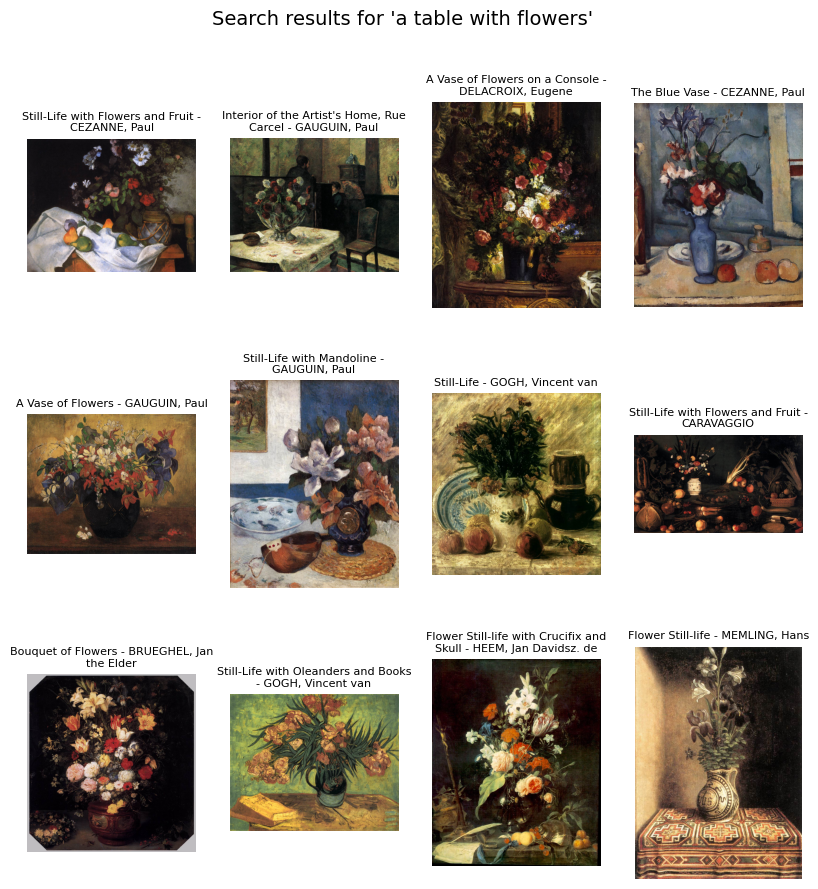

In [12]:
image_names = [row[0] for row in rows]
image_titles = [
    f"{row[2]} - {row[1]}" for row in rows
]
ncols = 4
nrows = math.ceil(len(image_names) / ncols)
display_image_grid(
    image_names=image_names,
    image_titles=image_titles,
    figure_title=f"Search results for '{text_prompt}'",
    nrows=nrows,
    ncols=ncols,
    container_client=blob_container_client,
)

As evident, all the paintings showcase a table with flowers. Through vector search, we successfully retrieved images similar to a text prompt by relying solely on the visual information present in the images, without utilizing metadata.

#### Query the table to find the cosine similarity

Let's modify the `SELECT` SQL query to retrieve the cosine similarity between the text prompt and the retrieved images.

In [13]:
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, 1 - ({c.VECTOR_COLUMN_NAME} <=> %s) AS cosine_similarity "
    f"FROM {table_name} ORDER BY cosine_similarity DESC "
    f"LIMIT {TOP_N};",
    (str(query_vector),),
)

# Retrieve the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(rows, columns=[c.IMAGE_FILE_COLUMN_NAME, "cosine_similarity"])
df_rows.head(TOP_N)

image_file  cosine_similarity
0    08537-2still2.jpg           0.344806
1    14903-early05.jpg           0.343476
2   11309-411delac.jpg           0.339657
3    08536-2still1.jpg           0.338456
4   14993-tahiti52.jpg           0.335774
5    14909-early11.jpg           0.334904
6   17036-flower09.jpg           0.333082
7   07635-89d_stil.jpg           0.331512
8   06614-bouquet1.jpg           0.330613
9   17114-3arles28.jpg           0.330286
10    19433-flower.jpg           0.328063
11  26109-30young1.jpg           0.327539

Display the retrieved images.

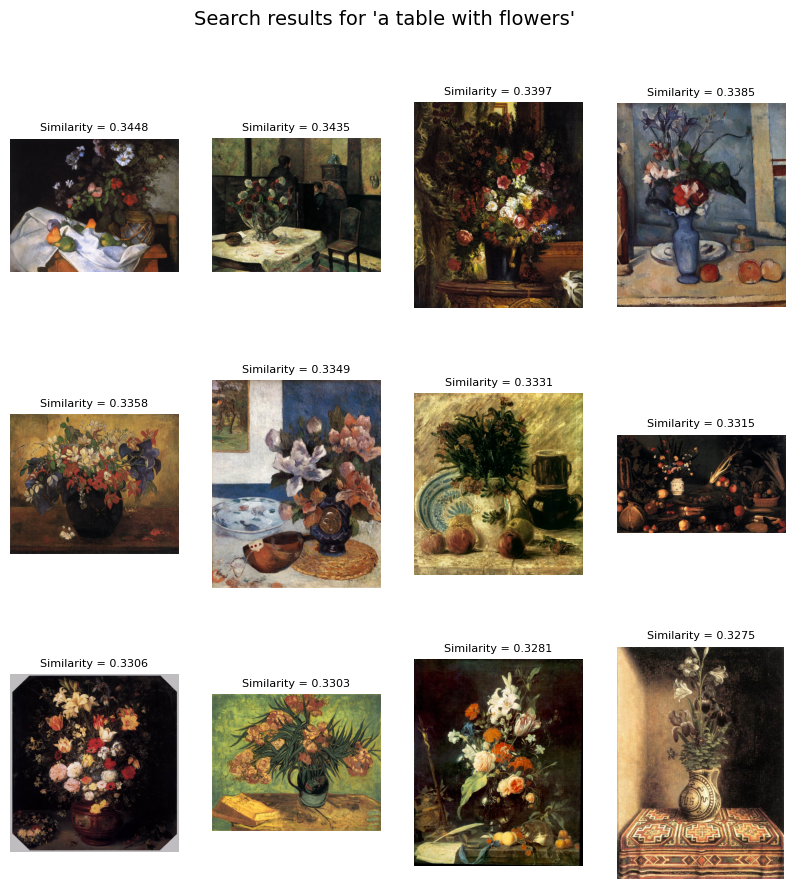

In [14]:
image_names = [row[0] for row in rows]
image_titles = [
    f"Similarity = {round(row[1], 4)}" for row in rows
]
ncols = 4
nrows = math.ceil(len(image_names) / ncols)
display_image_grid(
    image_names=image_names,
    image_titles=image_titles,
    figure_title=f"Search results for '{text_prompt}'",
    nrows=nrows,
    ncols=ncols,
    container_client=blob_container_client,
)

#### Metadata filtering

Filtering is an essential component of search systems, enabling users to narrow down search results, such as searching for paintings by Vincent van Gogh that depict a table with flowers. However, implementing accurate and fast metadata filtering in vector search systems is a challenging task. You can read the article [The Missing WHERE Clause in Vector Search](https://www.pinecone.io/learn/vector-search-filtering/) on the Pinecone blog to learn about the two fundamental approaches for metadata filtering and understand the complexities involved in implementing such filters into vector search applications.

In the following example, we will explore a basic approach for applying a filter using the SQL `WHERE` clause. Initially, we will filter based on the name of the artist to retrieve all paintings by Vincent van Gogh. Subsequently, we will conduct an exact nearest neighbor search to retrieve paintings that depict "a table with flowers."

You can find more information about filtering with the `pgvector` extension on the  [pgvector GitHub repository](https://github.com/pgvector/pgvector?tab=readme-ov-file#filtering).

In [15]:
# Vector search
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME}, "
    f"1 - ({c.VECTOR_COLUMN_NAME} <=> %s) AS cosine_similarity "
    f"FROM {table_name} "
    f"WHERE {c.AUTHOR_COLUMN_NAME} = 'GOGH, Vincent van' "
    f"ORDER BY cosine_similarity DESC "
    f"LIMIT {TOP_N};",
    (str(query_vector),),
)

# Retrieve the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(
    rows,
    columns=[c.IMAGE_FILE_COLUMN_NAME, c.AUTHOR_COLUMN_NAME, c.TITLE_COLUMN_NAME, "cosine_similarity"]
)
df_rows.head(TOP_N)

image_file             author  \
0   17036-flower09.jpg  GOGH, Vincent van   
1   17114-3arles28.jpg  GOGH, Vincent van   
2   17028-flower01.jpg  GOGH, Vincent van   
3   17034-flower07.jpg  GOGH, Vincent van   
4    17071-paris21.jpg  GOGH, Vincent van   
5   17038-flower11.jpg  GOGH, Vincent van   
6   17031-flower04.jpg  GOGH, Vincent van   
7   17030-flower03.jpg  GOGH, Vincent van   
8   17037-flower10.jpg  GOGH, Vincent van   
9   17033-flower06.jpg  GOGH, Vincent van   
10  17029-flower02.jpg  GOGH, Vincent van   
11   17142-arles64.jpg  GOGH, Vincent van   

                                                title  cosine_similarity  
0                                          Still-Life           0.333082  
1                 Still-Life with Oleanders and Books           0.330286  
2                         Bowl with Peonies and Roses           0.321057  
3                     Bowl with Zinnias and Geraniums           0.319091  
4                            Interior of a Restaurant           0.313070  
5                      Vase with Daisies and Anemones           0.312975  
6                 Vase with Zinnias and Other Flowers           0.311872  
7              Vase with Carnations and Other Flowers           0.311854  
8                   Vase with Cornflowers and Poppies           0.310618  
9                            Cineraria in a Flowerpot           0.308032  
10  Vase with Poppies, Cornflowers, Peonies and Ch...           0.305033  
11           Still-Life with Drawing Board and Onions           0.302710

Display the retrieved images.

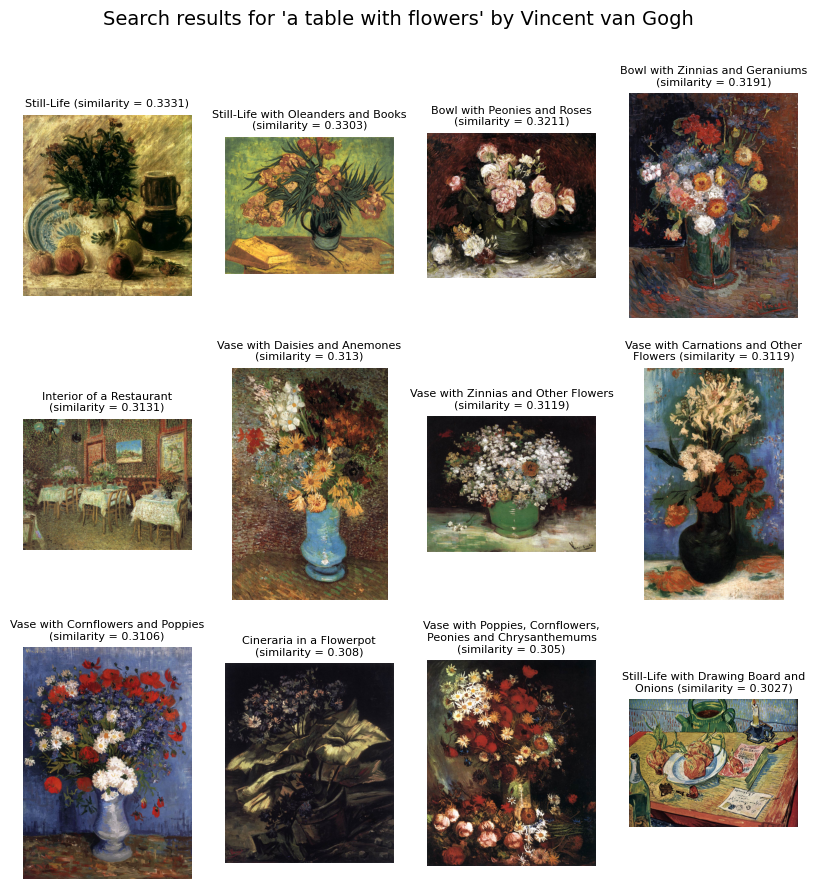

In [16]:
image_names = [row[0] for row in rows]
image_titles = [
    f"{row[2]} (similarity = {round(row[3], 4)})" for row in rows
]
ncols = 4
nrows = math.ceil(len(image_names) / ncols)
display_image_grid(
    image_names=image_names,
    image_titles=image_titles,
    figure_title=f"Search results for '{text_prompt}' by Vincent van Gogh",
    nrows=nrows,
    ncols=ncols,
    container_client=blob_container_client,
)

#### Retrieve paintings by Vincent van Gogh without applying any filters

In the previous example, we filtered the table by the name of the artist and then applied nearest neighbor search to find paintings depicting "a table with flowers." In this example, we will explore whether it's possible to retrieve paintings of a specific artist without applying filters by including their name in the text prompt.

In [17]:
text_prompt = "flowers by Vincent van Gogh"
query_vector = vectorize_text(
    text=text_prompt,
    endpoint=vision_endpoint,
    key=vision_key,
    version=vision_api_version,
)

In [18]:
# Vector search
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME}, "
    f"1 - ({c.VECTOR_COLUMN_NAME} <=> %s) AS cosine_similarity "
    f"FROM {table_name} "
    f"ORDER BY cosine_similarity DESC "
    f"LIMIT {TOP_N};",
    (str(query_vector),),
)

# Retrieve the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(
    rows,
    columns=[c.IMAGE_FILE_COLUMN_NAME, c.AUTHOR_COLUMN_NAME, c.TITLE_COLUMN_NAME, "cosine_similarity"]
)
df_rows.head(TOP_N)

image_file             author  \
0   17031-flower04.jpg  GOGH, Vincent van   
1   17114-3arles28.jpg  GOGH, Vincent van   
2   17038-flower11.jpg  GOGH, Vincent van   
3   17033-flower06.jpg  GOGH, Vincent van   
4   17034-flower07.jpg  GOGH, Vincent van   
5   17035-flower08.jpg  GOGH, Vincent van   
6   17030-flower03.jpg  GOGH, Vincent van   
7    17239-6still2.jpg  GOGH, Vincent van   
8   17259-auvers19.jpg  GOGH, Vincent van   
9    17240-6still3.jpg  GOGH, Vincent van   
10  17032-flower05.jpg  GOGH, Vincent van   
11  17171-1asylu04.jpg  GOGH, Vincent van   

                                                title  cosine_similarity  
0                 Vase with Zinnias and Other Flowers           0.401966  
1                 Still-Life with Oleanders and Books           0.401273  
2                      Vase with Daisies and Anemones           0.397258  
3                            Cineraria in a Flowerpot           0.391290  
4                     Bowl with Zinnias and Geraniums           0.381250  
5                       Fritillaries in a Copper Vase           0.380373  
6              Vase with Carnations and Other Flowers           0.376873  
7   Still-Life: Vase with Irises against a Yellow ...           0.373365  
8                         Daubigny's Garden at Auvers           0.371283  
9                                    Vase with Irises           0.370580  
10                              Vase with Red Poppies           0.369048  
11                                           The Iris           0.368205

Display the retrieved images.

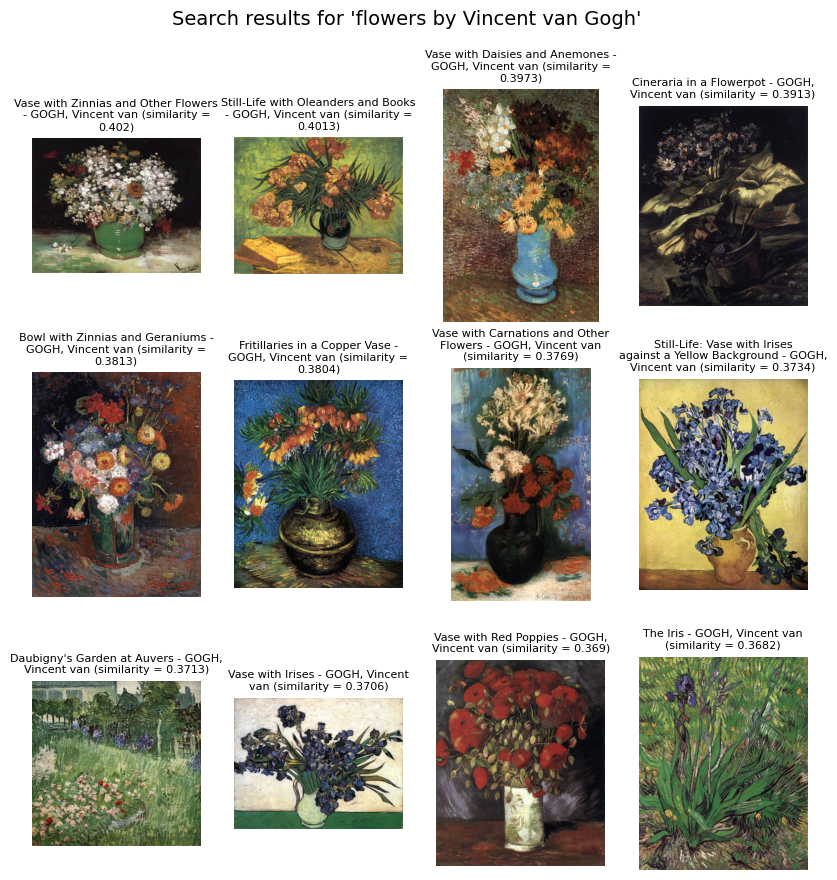

In [19]:
image_names = [row[0] for row in rows]
image_titles = [
    f"{row[2]} - {row[1]} (similarity = {round(row[3], 4)})" for row in rows
]
ncols = 4
nrows = math.ceil(len(image_names) / ncols)
display_image_grid(
    image_names=image_names,
    image_titles=image_titles,
    figure_title=f"Search results for '{text_prompt}'",
    nrows=nrows,
    ncols=ncols,
    container_client=blob_container_client,
)

We observe that we retrieve paintings depicting flowers by Vincent Van Gogh without filtering the table by the name of the artist.

Feel free to experiment with alternative text prompts and review the results. It's important to note that including the name of a specific artist in the text prompt **doesn't** guarantee that only paintings by that artist will be returned.

### Image-to-Image Search

#### Calculate the vector embeddings of the reference image

In the text-to-image search examples, we observed that we can retrieve images similar to the text prompt "a table with flowers" by calculating the cosine similarity between the vector of the paintings and the query. Let's explore if we can obtain paintings depicting a table with flowers, using another painting as a reference this time.

We will use the painting [*Still Life with Flowers* by Charles Ginner](https://artuk.org/discover/artworks/still-life-with-flowers-8115/search/actor:ginner-charles-18781952/page/1/view_as/grid).

In [20]:
reference_image = "reference_image.jpg"
query_vector = vectorize_image_with_filepath(
    image_filepath=reference_image,
    endpoint=vision_endpoint,
    key=vision_key,
    version=vision_api_version,
)

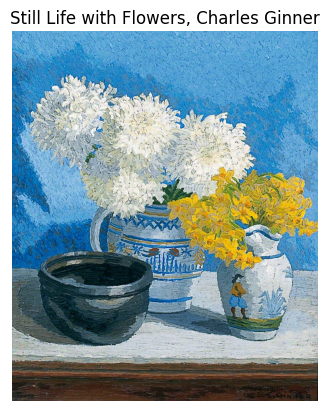

In [21]:
# Display the reference image
plt.imshow(Image.open(reference_image))
plt.axis("off")
plt.title("Still Life with Flowers, Charles Ginner")
plt.show()

#### Query the table to find the most similar images

In [22]:
# Vector search
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME}, "
    f"1 - ({c.VECTOR_COLUMN_NAME} <=> %s) AS cosine_similarity "
    f"FROM {table_name} ORDER BY cosine_similarity DESC "
    f"LIMIT {TOP_N};",
    (str(query_vector),),
)

# Retrieve the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(
    rows,
    columns=[c.IMAGE_FILE_COLUMN_NAME, c.AUTHOR_COLUMN_NAME, c.TITLE_COLUMN_NAME, "cosine_similarity"]
)
df_rows.head(TOP_N)

image_file             author  \
0   17036-flower09.jpg  GOGH, Vincent van   
1    08520-3still1.jpg      CEZANNE, Paul   
2   17034-flower07.jpg  GOGH, Vincent van   
3    14909-early11.jpg      GAUGUIN, Paul   
4   14993-tahiti52.jpg      GAUGUIN, Paul   
5   17037-flower10.jpg  GOGH, Vincent van   
6   17030-flower03.jpg  GOGH, Vincent van   
7   23815-6stilli1.jpg     MANET, Edouard   
8    08536-2still1.jpg      CEZANNE, Paul   
9   17033-flower06.jpg  GOGH, Vincent van   
10  17038-flower11.jpg  GOGH, Vincent van   
11   28609-1north3.jpg      MONET, Claude   

                                     title  cosine_similarity  
0                               Still-Life           0.767276  
1        Bouquet of Flowers in a Blue Vase           0.766351  
2          Bowl with Zinnias and Geraniums           0.762545  
3                Still-Life with Mandoline           0.755524  
4                        A Vase of Flowers           0.749016  
5        Vase with Cornflowers and Poppies           0.747376  
6   Vase with Carnations and Other Flowers           0.745661  
7            Vase of Peonies on a Pedestal           0.745579  
8                            The Blue Vase           0.737158  
9                 Cineraria in a Flowerpot           0.726479  
10          Vase with Daisies and Anemones           0.720490  
11                      Bouquet of Flowers           0.712136

Display the retrieved images.

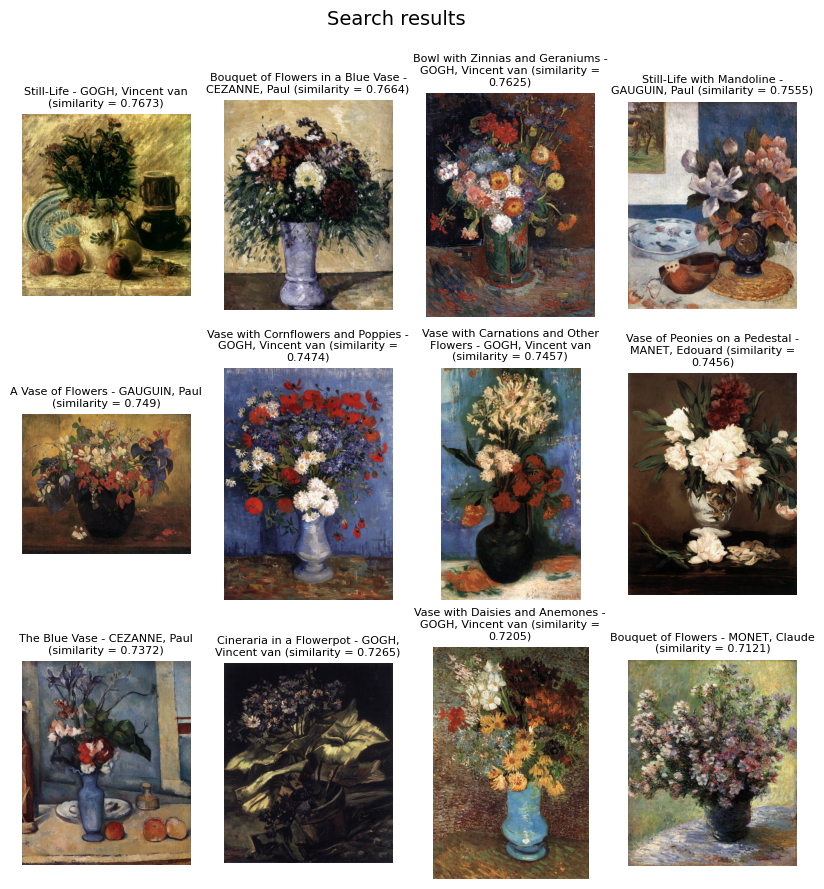

In [23]:
image_names = [row[0] for row in rows]
image_titles = [
    f"{row[2]} - {row[1]} (similarity = {round(row[3], 4)})" for row in rows
]
ncols = 4
nrows = math.ceil(len(image_names) / ncols)
display_image_grid(
    image_names=image_names,
    image_titles=image_titles,
    figure_title="Search results",
    nrows=nrows,
    ncols=ncols,
    container_client=blob_container_client,
)

#### Find the most similar images to an image of the dataset

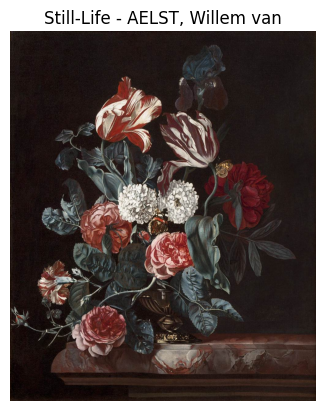

In [24]:
image_file = "00100-stillif.jpg"

# Download the image from Azure Blob Storage
image_stream = download_blob(
    image_filename=image_file,
    container_client=blob_container_client,
)

# Retrieve image metadata
cursor.execute(
    f"SELECT {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME} "
    f"FROM {table_name} "
    f"WHERE {c.IMAGE_FILE_COLUMN_NAME} = %s;",
    (image_file,),
)
metadata = cursor.fetchone()

# Display the reference image
plt.imshow(Image.open(image_stream))
plt.axis("off")
plt.title(f"{metadata[1]} - {metadata[0]}")
plt.show()

In [25]:
# Vector search
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME}, "
    f"1 - ({c.VECTOR_COLUMN_NAME} <=> (SELECT {c.VECTOR_COLUMN_NAME} FROM {table_name} WHERE {c.IMAGE_FILE_COLUMN_NAME} = %s)) "
    f"AS cosine_similarity "
    f"FROM {table_name} "
    f"WHERE {c.IMAGE_FILE_COLUMN_NAME} != %s "
    f"ORDER BY cosine_similarity DESC "
    f"LIMIT {TOP_N};",
    (image_file, image_file),
)

# Retrieve the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(
    rows,
    columns=[c.IMAGE_FILE_COLUMN_NAME, c.AUTHOR_COLUMN_NAME, c.TITLE_COLUMN_NAME, "cosine_similarity"]
)
df_rows.head(TOP_N)

image_file                   author  \
0   19473-vase_flo.jpg    HEEM, Jan Davidsz. de   
1   00095-stilflow.jpg        AELST, Willem van   
2   00107-vasewatc.jpg        AELST, Willem van   
3   19435-flowvase.jpg    HEEM, Jan Davidsz. de   
4   19455-festoon2.jpg    HEEM, Jan Davidsz. de   
5   02782-flowvase.jpg   AST, Balthasar van der   
6   00101-stillife.jpg        AELST, Willem van   
7    36423-bouquet.jpg         SAVERY, Roelandt   
8   06625-flowers9.jpg  BRUEGHEL, Jan the Elder   
9   06620-flowers4.jpg  BRUEGHEL, Jan the Elder   
10   20952-flowers.jpg       KESSEL, Jan van, I   
11  02788-stillif2.jpg   AST, Balthasar van der   

                                        title  cosine_similarity  
0                             Vase of Flowers           0.919311  
1                                  Still-Life           0.916634  
2           Vase of Flowers with Pocket Watch           0.910945  
3                           Vase with Flowers           0.900396  
4              Festoon with Flowers and Fruit           0.891418  
5   Flowers in a Vase with Shells and Insects           0.887366  
6                           Flower Still-Life           0.886898  
7                          Bouquet of Flowers           0.886468  
8   Still-Life of Flowers in a Stoneware Vase           0.885186  
9                           Flowers in a Vase           0.882053  
10                                    Flowers           0.881389  
11                          Flower Still-Life           0.880050

Display the retrieved images.

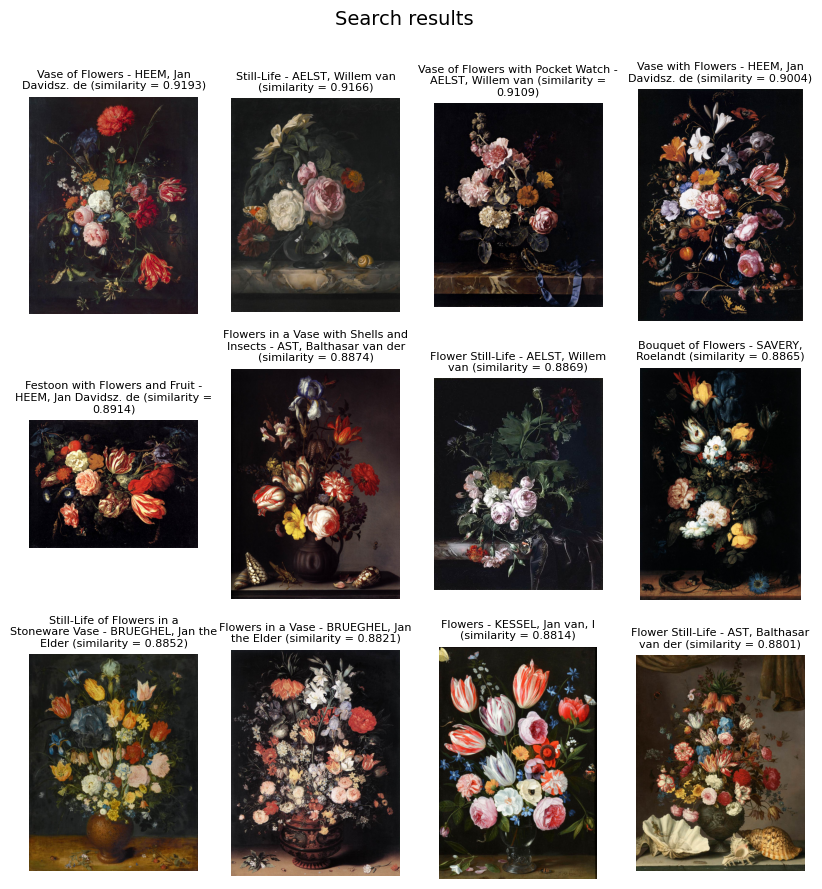

In [26]:
image_names = [row[0] for row in rows]
image_titles = [
    f"{row[2]} - {row[1]} (similarity = {round(row[3], 4)})" for row in rows
]
ncols = 4
nrows = math.ceil(len(image_names) / ncols)
display_image_grid(
    image_names=image_names,
    image_titles=image_titles,
    figure_title="Search results",
    nrows=nrows,
    ncols=ncols,
    container_client=blob_container_client,
)

We notice that the images are not only semantically similar, depicting a table with flowers, but they also share similarities in their colors.

Let's explore one more example. This time, we will use the painting "Gauguin's Chair" by Vincent van Gogh as a reference.

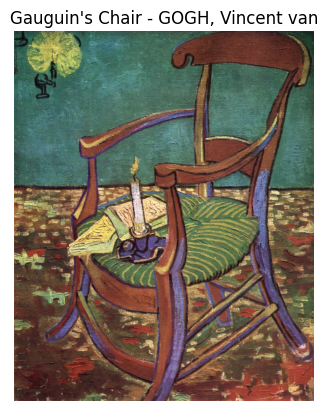

In [27]:
painting_title = "Gauguin's Chair"
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME} "
    f"FROM {table_name} "
    f"WHERE {c.TITLE_COLUMN_NAME} = %s;",
    (painting_title,),
)
painting_info = cursor.fetchone()

# Download the image from Azure Blob Storage
image_stream = download_blob(
    image_filename=painting_info[0],
    container_client=blob_container_client,
)

# Display the reference image
plt.imshow(Image.open(image_stream))
plt.axis("off")
plt.title(f"{painting_title} - {painting_info[1]}")
plt.show()

In [28]:
# Vector search
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME}, "
    f"1 - ({c.VECTOR_COLUMN_NAME} <=> (SELECT {c.VECTOR_COLUMN_NAME} FROM {table_name} WHERE {c.IMAGE_FILE_COLUMN_NAME} = %s)) "
    f"AS cosine_similarity "
    f"FROM {table_name} "
    f"WHERE {c.IMAGE_FILE_COLUMN_NAME} != %s "
    f"ORDER BY cosine_similarity DESC "
    f"LIMIT {TOP_N};",
    (painting_info[0], painting_info[0]),
)

# Retrieve the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(
    rows,
    columns=[c.IMAGE_FILE_COLUMN_NAME, c.AUTHOR_COLUMN_NAME, c.TITLE_COLUMN_NAME, "cosine_similarity"]
)
df_rows.head(TOP_N)

image_file             author  \
0    17137-arles59.jpg  GOGH, Vincent van   
1   17230-4earlie1.jpg  GOGH, Vincent van   
2   17114-3arles28.jpg  GOGH, Vincent van   
3   17166-portra18.jpg  GOGH, Vincent van   
4   17231-4earlie2.jpg  GOGH, Vincent van   
5    17126-arles48.jpg  GOGH, Vincent van   
6   17164-portra16.jpg  GOGH, Vincent van   
7    17049-still08.jpg  GOGH, Vincent van   
8    17120-arles42.jpg  GOGH, Vincent van   
9   17157-portra09.jpg  GOGH, Vincent van   
10  15021-marque04.jpg      GAUGUIN, Paul   
11  17232-4earlie3.jpg  GOGH, Vincent van   

                                                title  cosine_similarity  
0                       Vincent's Chair with His Pipe           0.818030  
1                          Vincent's Bedroom in Arles           0.774622  
2                 Still-Life with Oleanders and Books           0.763668  
3                      La Berceuse (Augustine Roulin)           0.749045  
4                          Vincent's Bedroom in Arles           0.746039  
5                          Vincent's Bedroom in Arles           0.743581  
6   Portrait of Madame Augustine Roulin (La Berceuse)           0.743000  
7            Still-Life with French Novels and a Rose           0.740469  
8   Cafe Terrace on the Place du Forum, Arles, at ...           0.736886  
9              L'Arlesienne: Madame Ginoux with Books           0.736557  
10                              Sunflowers in a Chair           0.732102  
11             Old Man in Sorrow (At Eternity's Gate)           0.731537

Display the retrieved images.

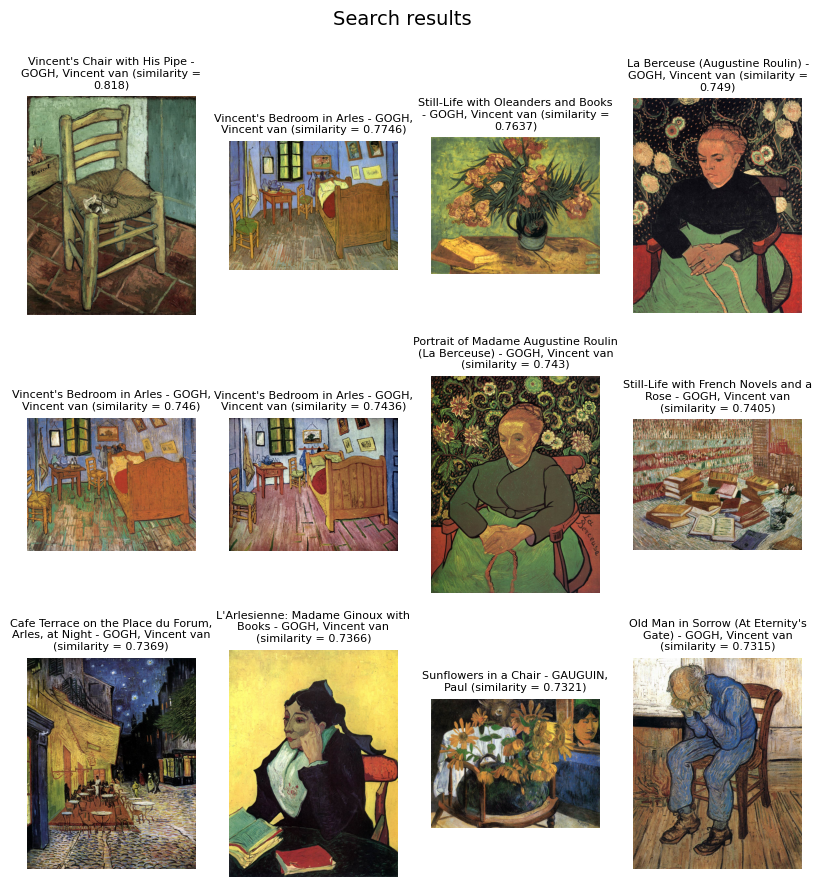

In [29]:
image_names = [row[0] for row in rows]
image_titles = [
    f"{row[2]} - {row[1]} (similarity = {round(row[3], 4)})" for row in rows
]
ncols = 4
nrows = math.ceil(len(image_names) / ncols)
display_image_grid(
    image_names=image_names,
    image_titles=image_titles,
    figure_title="Search results",
    nrows=nrows,
    ncols=ncols,
    container_client=blob_container_client,
)

We notice that the paintings retrieved by the query are by Vincent van Gogh and depict chairs. Additionally, there is a painting by Paul Gauguin that also depicts a chair.

## Close the connection

In [30]:
conn.commit()
cursor.close()
conn.close()